# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [3]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

# Useful functions 
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = np.int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()
    
from TME1 import openImage, replacePixels, histogramEqualization, computeHistogram
from TME2 import rotateImage

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [2]:
 
def computeR(I,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    Sx = np.array(([1,0,-1],
                  [2,0,-2],
                  [1,0,-1]))
    Sy = Sx.T
    
    Ix = scipy.signal.convolve2d(I, Sx, mode='same')
    Iy = scipy.signal.convolve2d(I, Sy, mode='same')
    
    Ix2 = Ix*Ix
    Iy2 = Iy*Iy
    IxIy = Ix*Iy
    
    sigma = int(round(scale)-1)/6
    A = scipy.signal.convolve2d(Ix2, gaussianKernel(sigma), mode='same')
    B = scipy.signal.convolve2d(Iy2, gaussianKernel(sigma), mode='same')
    C = scipy.signal.convolve2d(IxIy, gaussianKernel(sigma), mode='same')
    R = np.zeros(I.shape)
    
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            M = np.array(([A[i,j],C[i,j]],
                          [C[i,j],B[i,j]]))
            d = np.linalg.det(M)
            t = np.trace(M)
            R[i,j] = d - kappa*t*t
    
    return R  

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

In [4]:
I = openImage('img/house2.png')
W = 15
kappa = 0.04

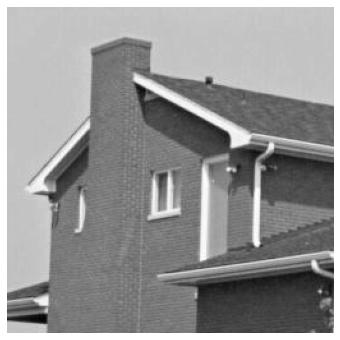

<ipython-input-3-f57e045aaacf>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n2 = np.int(np.ceil(3*sigma))


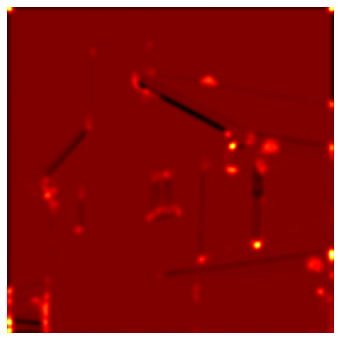

In [5]:
imshow(I)
R = computeR(I, W, kappa)
imshow_hot(R)

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

We have the following (as expected) : 
- $R < 0 \Rightarrow$ one eigenvalue is $\approx$ null  
thus we have edges displayed in dark lines.
- $R = 0 \Rightarrow$ both eigenvalues are $\approx$ null  
and we have regions displayed as grey/red shapes
- $R > 0 \Rightarrow$ both eigenvalues are positive and of the same order  
and we have corners displayed as bright spots

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

In [6]:
def thresholdR(R, thresh):
    """ Array[n, m] * float -> Array[n, m]
    """
    return np.where(R>thresh, 1, 0)

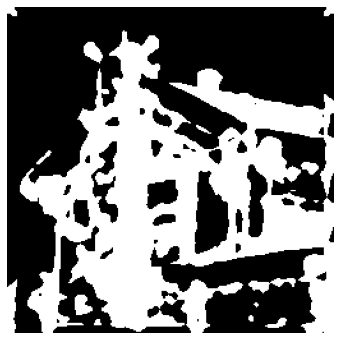

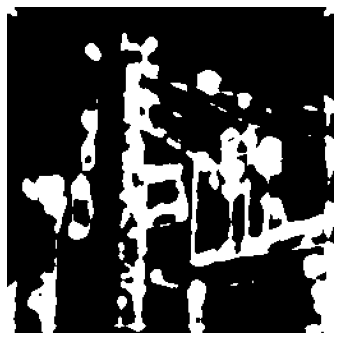

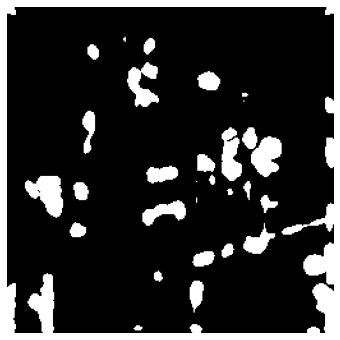

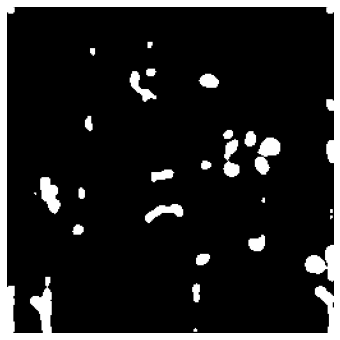

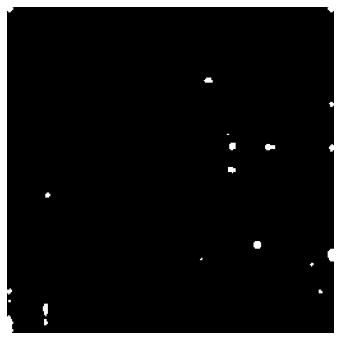

In [7]:
for i in range(5,10):
    Rbin = thresholdR(R, 10**i)
    imshow(Rbin)

**We see that we get interesting results for threshold values between $1e8$ and $1e9$.  
Thus, we'll set $5e8$ as our threshold value for the upcoming steps.**

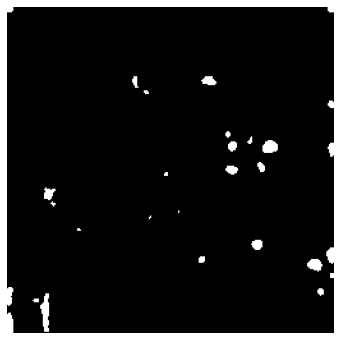

In [8]:
Rbin = thresholdR(R, 5e8)
imshow(Rbin)

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [9]:
def isLocalMax(R, i, j):
    return max(R[i-1,j],R[i,j],R[i+1,j],R[i-1,j-1],R[i-1,j+1],R[i,j-1],R[i,j+1],R[i+1,j-1],R[i+1,j+1]) == R[i,j]

def rnms(R, Rbin):
    """ Array[n, m] -> Array[n, m] 
    """
    Rlocmax = np.zeros(R.shape)
    
    for i in range(1,Rbin.shape[0]-1):
        for j in range(1,Rbin.shape[1]-1):
            if Rbin[i,j] == 1:
                if isLocalMax(R,i,j):
                    Rlocmax[i,j] = 1
    return Rlocmax        

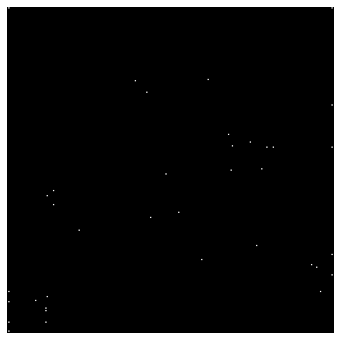

In [10]:
imshow(rnms(R,Rbin))

3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [11]:
def cornerDetector(image, scale, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    R = computeR(image, scale, kappa)
    Rbin = thresholdR(R, thres)
    return rnms(R,Rbin)

<ipython-input-3-f57e045aaacf>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n2 = np.int(np.ceil(3*sigma))


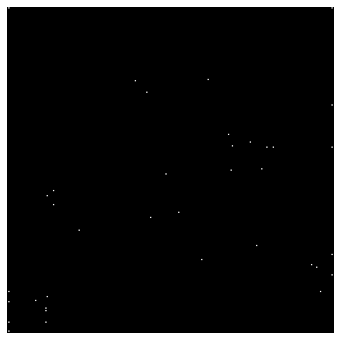

In [12]:
scale = 15
kappa = 0.04
thres = 5e8

cornerDetected = cornerDetector(I, scale, kappa, thres)
imshow(cornerDetected)

4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

In [24]:
def displayCorners(image, cornerDetected,label):
    x, y = np.nonzero(cornerDetected)
    
    img = plt.imread(image)
    fig, ax = plt.subplots()
    ax.set_title(label)
    ax.imshow(img)
    ax.scatter(y, x, color='firebrick')
    return x.shape[0]

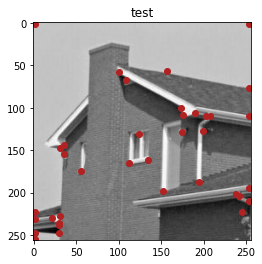

In [14]:
displayCorners("img/house2.png", cornerDetected, 'test')

5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

**Now that we have a better way of evaluating the results of our corner detector, let's see what we get with different values $thres$ and $scale$.**

**More precisely, we'll take $thres\in [1e6, 1e9]$ and $scale \in [3, 51]$.**

**And we increase both parameters**

<ipython-input-3-f57e045aaacf>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n2 = np.int(np.ceil(3*sigma))
<ipython-input-13-5eb1cc2b91a9>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


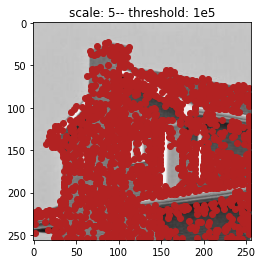

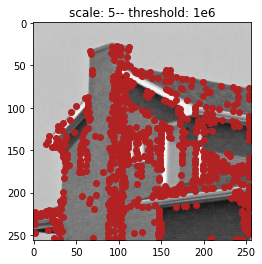

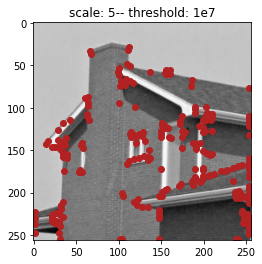

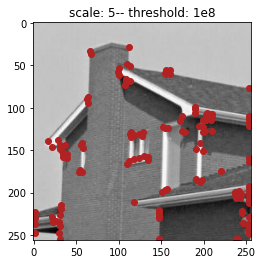

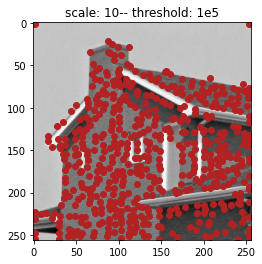

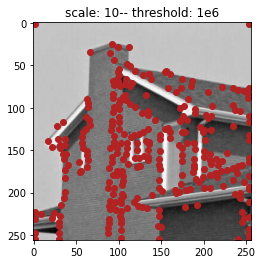

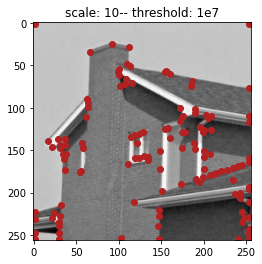

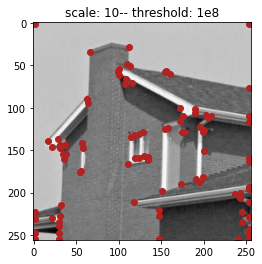

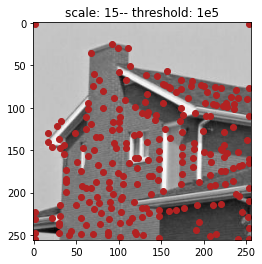

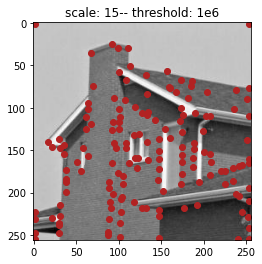

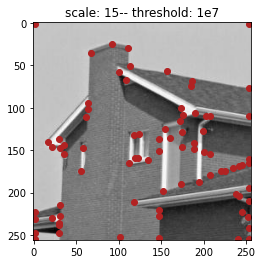

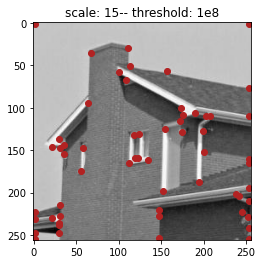

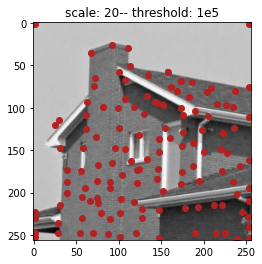

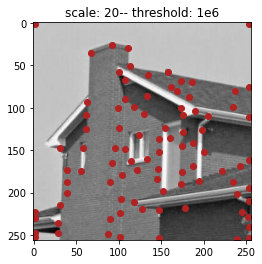

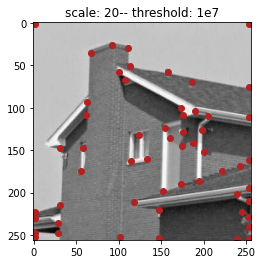

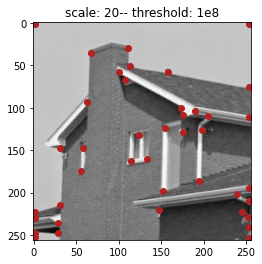

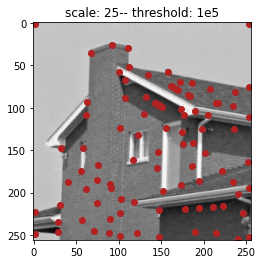

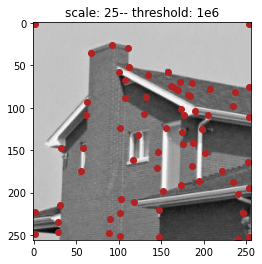

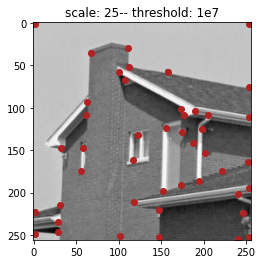

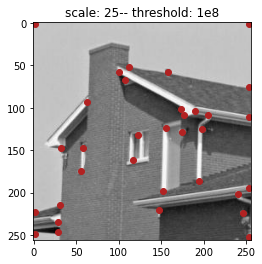

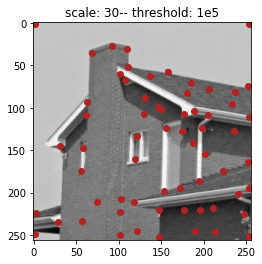

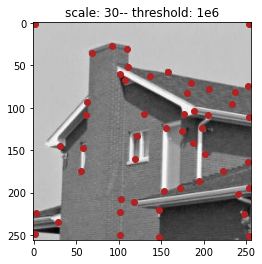

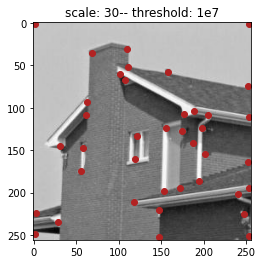

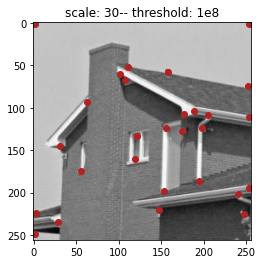

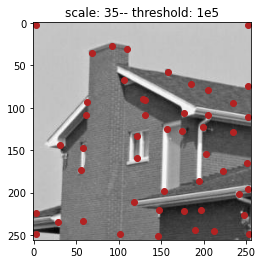

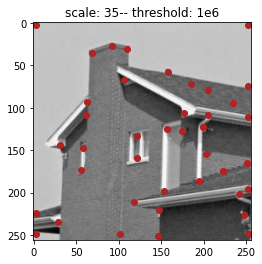

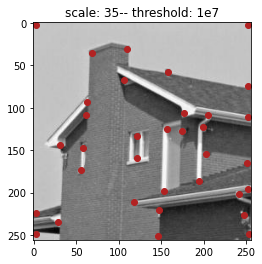

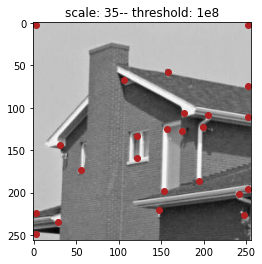

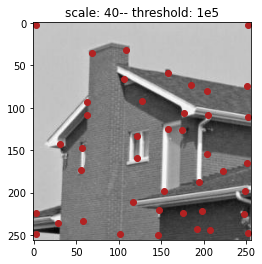

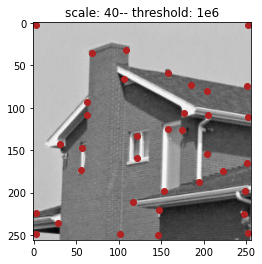

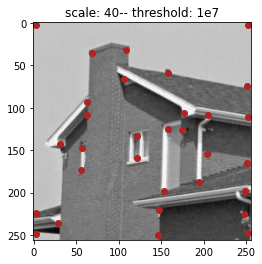

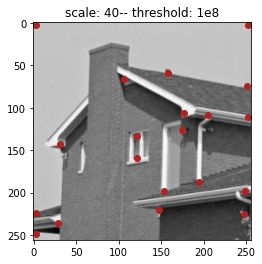

In [15]:
filename = "img/house2.png"
kappa = 0.04
for scale in range(5,45,5):
    for thres in range(5,9):
        label = 'scale: '+str(scale)+'-- threshold: 1e'+str(thres)
        displayCorners(filename, cornerDetector(I,scale,kappa, 10**thres), label)

**One can see that scale and threshold are intertwined :  
The higher the scale, the lower the threshold needs to be if one wants to detect something and vice versa. Whenever the scale is small, the threshold needs to be high orelse the algorithms detects corners along edges, which seems reasonable (on a 5x5 Window, edges do not appear straight and thus we get two non-null eigenvalues instead of one).**

**Good pairs of `threshold` and `scale` values could be :  
We see that in order to see just enough details, the window size should be between 15 and 20 pixel-large with a high enough threshold.**

**Otherwise, we get the confusion with the roof texture or the shadows on the walls.**

**Please do remember that this detector has one (quite huge) flaw :  
as it removes non-local-maxima, of multiple 'real' corners that are too close to each other, only a single one will appear on the final detection. Hence the need of smaller windows, but then it comes with the other downsides we just discussed.**

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

In [16]:
scale = 15
thres = 1e8

f1 = 'img/toyHorse1.png'
f2 = 'img/toyHorse2.png'
th1 = openImage(f1)
th2 = openImage(f2)

<ipython-input-3-f57e045aaacf>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n2 = np.int(np.ceil(3*sigma))


There is 133 corners detected


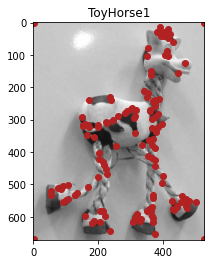

In [25]:
nbCorners = displayCorners(f1, cornerDetector(th1,scale,kappa, thres), 'ToyHorse1')
print(f"There is {nbCorners} corners detected")

<ipython-input-3-f57e045aaacf>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n2 = np.int(np.ceil(3*sigma))


There is 48 corners detected


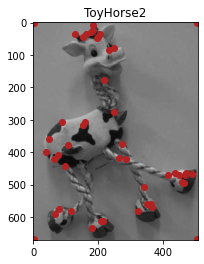

In [26]:
nbCorners = displayCorners(f2, cornerDetector(th2,scale,kappa, thres), 'ToyHorse2')
print(f"There is {nbCorners} corners detected")

2) What are the dynamic ranges of these two images ?

In [19]:
print('L Toyhorse1 : ', np.max(th1) - np.min(th1)) 
print('L Toyhorse2 : ', np.max(th2) - np.min(th2))
print('Average intensity value Th1 : ', np.mean(th1))
print('Average intensity value Th2 : ', np.mean(th2))

L Toyhorse1 :  254
L Toyhorse2 :  253
Average intensity value Th1 :  166.47176838599333
Average intensity value Th2 :  111.72060012286998


3) What are the transformations beetween the two images ?

**The second image is both an affine transformation of brightness and a rotation of the first image**

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

**We want to determine whether, the detector is invariant to rotation.**
**We will apply some rotations to the Toy Horse and see if the number of corners detected is still the same.**

<ipython-input-3-f57e045aaacf>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n2 = np.int(np.ceil(3*sigma))


There is 144 corners detected


<Figure size 432x288 with 0 Axes>

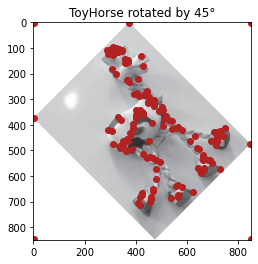

In [27]:
horseRotated = rotateImage(th1, 45.0)
fig = plt.figure()
# imshow(horseRotated)
nbCorners = displayCorners('img/ToyHorse1Rotated45.png', cornerDetector(horseRotated,scale,kappa, thres), 'ToyHorse rotated by 45°')
print(f"There is {nbCorners} corners detected")

<ipython-input-3-f57e045aaacf>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n2 = np.int(np.ceil(3*sigma))


There is 133 corners detected


<Figure size 432x288 with 0 Axes>

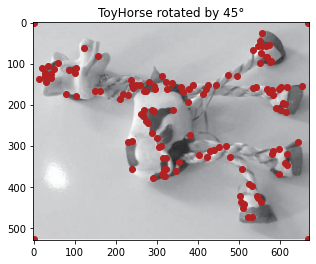

In [28]:
horseRotated = rotateImage(th1, 90.0)
fig = plt.figure()
# imshow(horseRotated)
nbCorners = displayCorners('img/ToyHorse1Rotated90.png', cornerDetector(horseRotated,scale,kappa, thres), 'ToyHorse rotated by 45°')
print(f"There is {nbCorners} corners detected")

<ipython-input-3-f57e045aaacf>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n2 = np.int(np.ceil(3*sigma))


There is 133 corners detected


<Figure size 432x288 with 0 Axes>

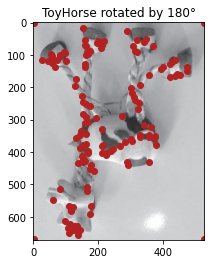

In [29]:
horseRotated = rotateImage(th1, 180.0)
fig = plt.figure()
# imshow(horseRotated)
nbCorners = displayCorners('img/ToyHorse1Rotated180.png', cornerDetector(horseRotated,scale,kappa, thres), 'ToyHorse rotated by 180°')
print(f"There is {nbCorners} corners detected")

**As we can see, doing some rotations does not change the number of corners detected, which is still 133. This is not true for other angles than 90, 180 or 270 thought. This is explained by the fact that rotates an image with another angle lose information and change the size of the result, more corners will then be detected.**

**Thus, we can conclude that this detector is invariant to rotation.** 

kmax :  253 most common value :  137
kmax :  255 most common value :  197


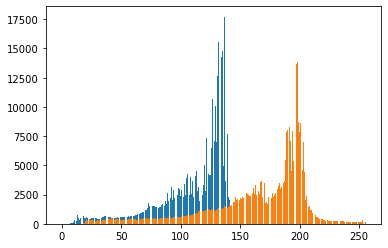

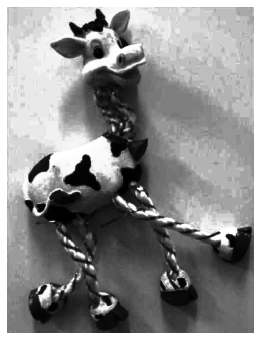

In [31]:
x = np.arange(256)
H = computeHistogram(th2)
plt.figure(26)
plt.bar(x, H)
H = np.array(H)
print('kmax : ',th2.max(), 'most common value : ', th2.min()+np.argmax(H))

horse2Equalized = histogramEqualization(th2, H)

H = computeHistogram(th1)
plt.figure(26)
plt.bar(x, H)
H = np.array(H)
print('kmax : ',th1.max(), 'most common value : ', th1.min()+np.argmax(H))



imshow(horse2Equalized)

<ipython-input-3-f57e045aaacf>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n2 = np.int(np.ceil(3*sigma))


There is 265 corners detected


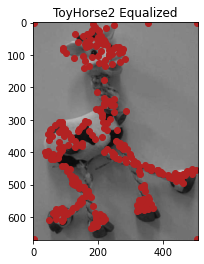

In [32]:
nbCorners2 = displayCorners(f2, cornerDetector(horse2Equalized,scale,kappa, thres), 'ToyHorse2 Equalized')
print(f"There is {nbCorners2} corners detected")

**We can notice that the first image is more contrasted than the second. By equalising the second image to increase the contrasts, we also increase the number of corners detected.**

**In order to ensure that the Harris corner detection is invariant to affine transformation, 
We'll perform several affine transformation and a single histogram equalization onto a set of images. We expect that, using a fixed threshold, the detection will not be robust to these transformations. In other words, the detection won't return the same ($+$\$-$ $\epsilon$) number of corners**

Let's modify our `displayCorners` function so that it returns the number of detected corners

In [21]:
def displayNumberOfCorners(cornerDetected):
    x, y = np.nonzero(cornerDetected)
    return x.shape[0]

In [105]:
thres = 1e8
kappa = 0.04
scale = 15

In [106]:
# Image Set
I = openImage('img/Jussieu_wikipedia.jpg')
image = 'img/Jussieu_wikipedia.jpg'
iList = []
iList.append(0.5*I)
iList.append(I)
iList.append(1.5*I)
iList.append(histogramEqualization(I, computeHistogram(I)))

/tmp/ipykernel_3684/2731956920.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n2 = np.int(np.ceil(3*sigma))


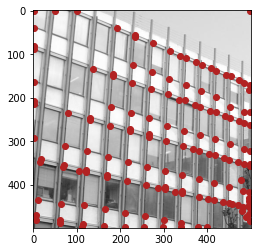

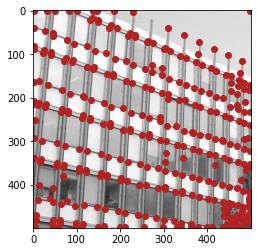

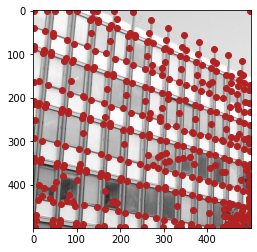

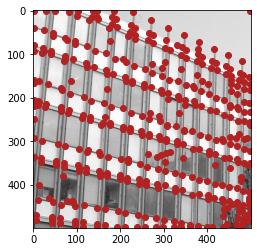

In [107]:
# Results
x = []
for i in iList:
    c = cornerDetector(i,scale,kappa,thres)
    displayCorners(image, c, '')
    x.append(displayNumberOfCorners(c))

<BarContainer object of 4 artists>

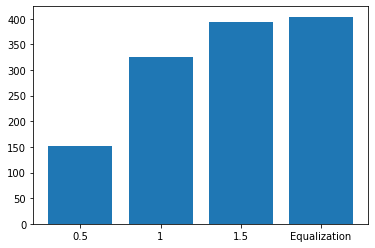

In [108]:
labels = ['0.5', '1', '1.5', 'Equalization']
y = [j for j in range(len(labels))]
plt.bar(y,x, tick_label=labels)


**We can observe that the brighter the image, the more corners are detected.**

**Thus, we conclude that *with a fixed threshold*, the Harris corner detection is not robust to affine brightness transformation.**  
**The threshold needs to be adjusted according to the average brightness of the image.**

**Also, the results obtained with `histogramEqualization` tend to hint that higher contrast leads to a better corner detection**

### Kappa Variations

As we saw in tutorial work, the corner detection requires $kappa$ to be not too small nor too great.  
In fact, we took `kappa` $= 0.04$ during this entire session, knowing that kappa should stay in the interval $[0.04, 0.06]$.  
We propose to experimentally verify this with the following steps :  

We'll take `kappa` $\in [0.01, 0.04, 0.1, 0.24, 0.25]$ and see wether or not these changes have an impact on corner detection.

In [93]:
scale = 15
thres = 1e8

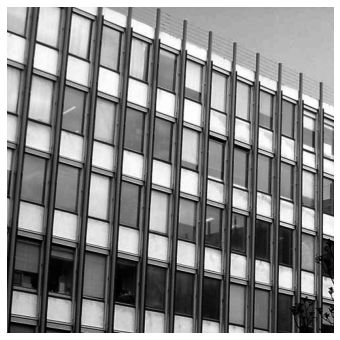

In [94]:
# We'll take the histogram equalization of Jussieu as our onlly image this time
image = 'img/Jussieu_wikipedia.jpg'
I = histogramEqualization(I, computeHistogram(I))
imshow(I)

In [95]:
x = []
y = [i for i in range(5)]

/tmp/ipykernel_3684/2731956920.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n2 = np.int(np.ceil(3*sigma))


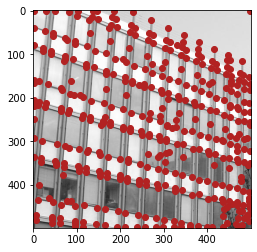

In [96]:
kappa = 0.01
c=cornerDetector(i,scale,kappa, thres)
x.append(displayNumberOfCorners(c))
displayCorners(image, c,'')

/tmp/ipykernel_3684/2731956920.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n2 = np.int(np.ceil(3*sigma))


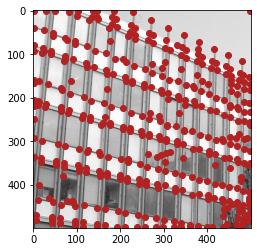

In [97]:
kappa = 0.04
c=cornerDetector(i,scale,kappa, thres)
x.append(displayNumberOfCorners(c))
displayCorners(image, c,'')

/tmp/ipykernel_3684/2731956920.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n2 = np.int(np.ceil(3*sigma))


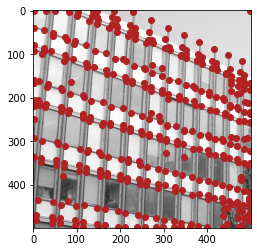

In [98]:
kappa = 0.1
c=cornerDetector(i,scale,kappa, thres)
x.append(displayNumberOfCorners(c))
displayCorners(image, c,'')

/tmp/ipykernel_3684/2731956920.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n2 = np.int(np.ceil(3*sigma))


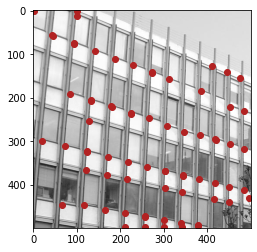

In [99]:
kappa = 0.24
c=cornerDetector(i,scale,kappa, thres)
x.append(displayNumberOfCorners(c))
displayCorners(image, c,'')

/tmp/ipykernel_3684/2731956920.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n2 = np.int(np.ceil(3*sigma))


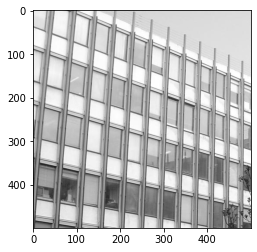

In [100]:
kappa = 0.25
c=cornerDetector(i,scale,kappa, thres)
x.append(displayNumberOfCorners(c))
displayCorners(image, c,'')

5 5


<BarContainer object of 5 artists>

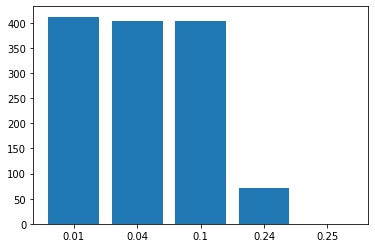

In [89]:
labels = ['0.01', '0.04', '0.1', '0.24', '0.25']
print(len(x), len(y))
plt.bar(y,x,tick_label=labels)

We showed that in order to properly detect corners, `kappa` needs to be small enough, in theory $kappa \leq 0.24$, although in practice we should say $kappa \leq 0.1$ to detect all corners.

Furthermore, the same demonstration could be made for edge detection to show that `kappa` needs to be high enough.

Hence we took $kappa \in [0.04, 0.06]$ in this notebook.